# `intersection_area_over_object_area` explained

This notebook illustrates how the `intersection_area_over_object_area` variable works.

We create two label images: one with a square and another with a triangle. We then slide the triangle over the square, like shown below.

We display both labeled images in a single image for illustration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ref_labels = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
probe_labels = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
probe_list = [np.roll(probe_labels, i, axis=1) for i in range(6)]

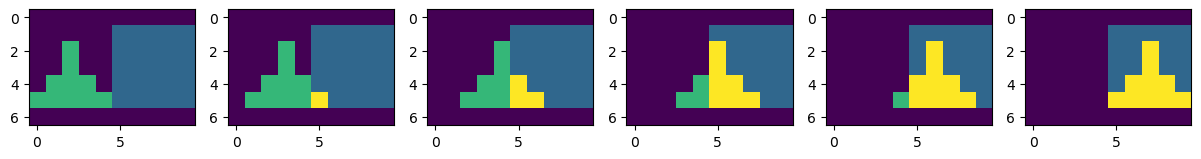

In [3]:
fig, ax = plt.subplots(1,6, figsize = [15,2])
for i, probe in enumerate(probe_list):
    ax[i].imshow(ref_labels + probe, vmax=3)

## Metrics of overlap

Imagine we want to know whether the triangle 'belongs' to the square or not. We could use the Jaccard index (or *IoU*), defined below:

$ IoU = \frac{\Delta \cap \square }{\Delta \cup \square } $

But if the square is much bigger, the jaccard index is still low. It does not portraits how much of the triangle is 'inside' the square.
Therefore, we need a different metric for that.

We could use the intersection divided by the area of the object of interest, in this case, the triangle:

$ Io\_Object\_Area = \frac{\Delta \cap \square }{\Delta } $

This tells us, in this example, how much of the triangle area is yellow.

Below, we plot both metrics to highlight the difference:

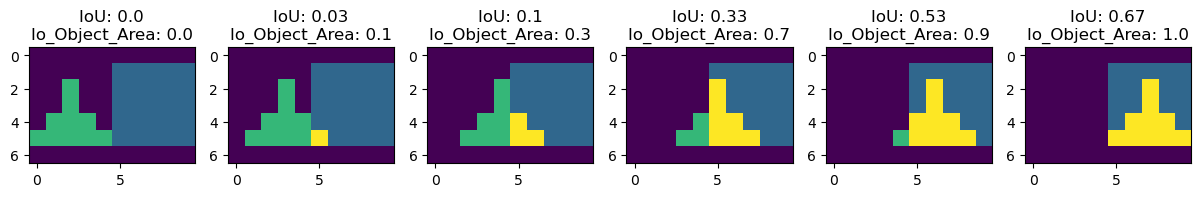

In [4]:
fig, ax = plt.subplots(1,6, figsize = [15,2])
for i, probe in enumerate(probe_list):
    image = ref_labels + probe
    intersection_area = len(image[image == 3])
    union_area = len(image[(image < 3) & (image != 0)])
    triangle_area = len(probe[probe == 2])
    
    IoU = intersection_area / union_area
    Io_object_area = intersection_area / triangle_area
    
    ax[i].imshow(image, vmax=3)
    ax[i].set_title('IoU: ' + str(np.around(IoU,2)) + '\nIo_Object_Area: ' + str(np.around(Io_object_area,2)))

In the `regionprops_map_channels_table` function, the `intersection_area_over_object_area` parameter is actually a threshold for this 'Io_Object_Area' metric.

This means that, for example, if we choose `intersection_area_over_object_area = 0.1`, then if an object in a first channel whose 10% of its area or more overalaps with an object in second channel, this first object is considered to 'belong' to the second. On the other hand, if we choose `intersection_area_over_object_area = 1`, then an object in the first channel only belongs to the second if it is fully 'inside' the second.

Below we define the function `highest_overlap`, which is the one used to define these relationships and display the same images as before with different `intersection_area_over_object_area` values.

In [5]:
def highest_overlap(regionmask, intensity_image,
                        overlap_threshold=0.5):
    regionmask = regionmask.astype(bool)
    if overlap_threshold == 0:
        return 0
    values, counts = np.unique(np.sort(intensity_image[regionmask]),
                               return_counts=True)
    
    # Probabilities of belonging to a certain label or bg
    probs = counts/np.sum(counts)
    # If there is underlying bg, take it out
    if values[0] == 0:
        values = np.delete(values, 0)
        probs = np.delete(probs, 0)

    # if any label overlap probability is bigger than overlap_threshold
    if (probs >= overlap_threshold).any():
        # find label with highest overlap
        # if equal frequency, return first occurence
        index_max_overlap_prob = np.argmax(probs)
        value = values[index_max_overlap_prob]
    else:  # otherwise, highest allowed overlap is considered to be
        # with background, i.e., object does not "belong" to any
        #  other label and gets 0
        value = 0
    return value

In [6]:
label_dict = {0: 'bg', 1: 'square'} #bg means background

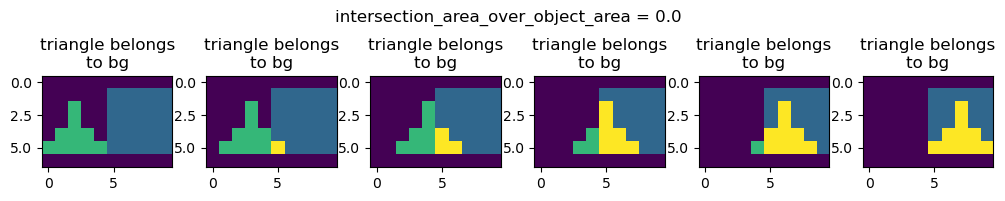

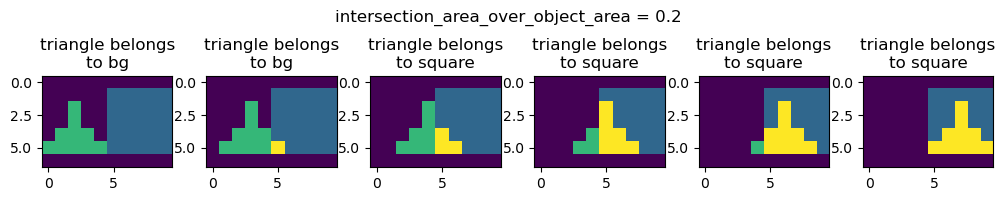

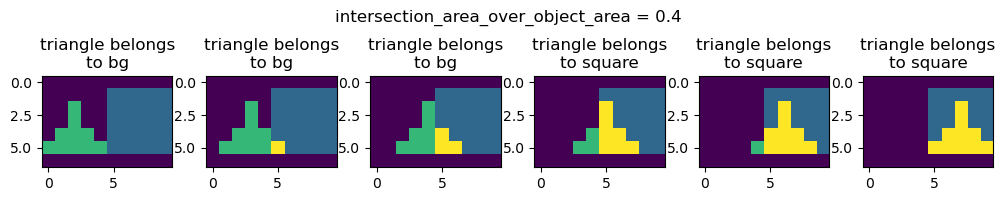

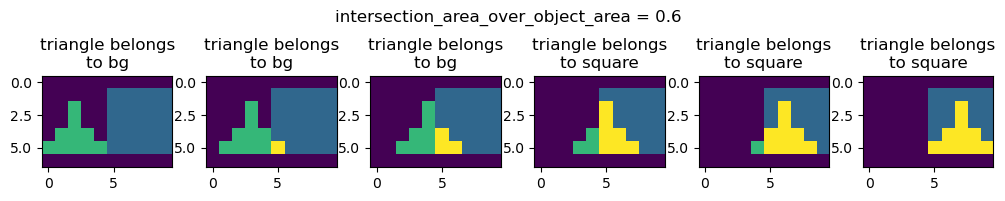

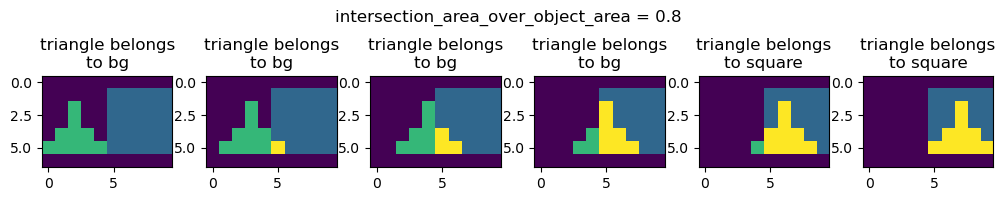

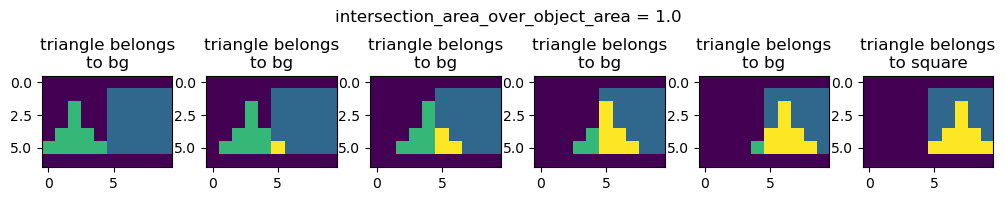

In [10]:
for i in range(6):
    intersection_area_over_object_area = i/5
    
    fig, ax = plt.subplots(1,6, figsize = [10,2])
    title = 'intersection_area_over_object_area = ' + str(intersection_area_over_object_area)
    plt.suptitle(title)
    for i, probe in enumerate(probe_list):
        ax[i].imshow(ref_labels + probe, vmax=3)
        value = highest_overlap(regionmask = probe, intensity_image = ref_labels,
                            overlap_threshold=intersection_area_over_object_area)
        ax[i].set_title('triangle belongs\nto ' + label_dict[value])
    plt.tight_layout()

## Multi-label example

If we have two 'square' labels, the behavior is the same: the triangle will belong to the one which encompasses more than `intersection_area_over_object_area` of the triangle area.

Notice that, if none of the squares can fit this criterion (like in some cases when `intersection_area_over_object_area` > 0.8), then the triangle is considered to belong to the background.

In [11]:
ref_labels2 = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
    [2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [12]:
label_dict = {0: 'bg', 1: 'square1', 2: 'square2'} #bg means background

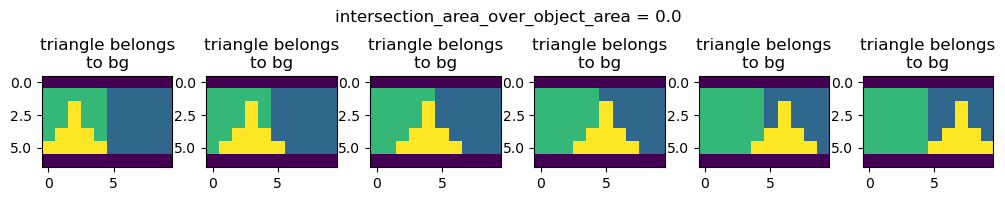

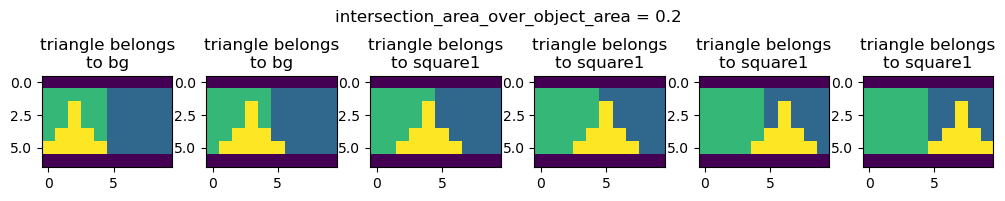

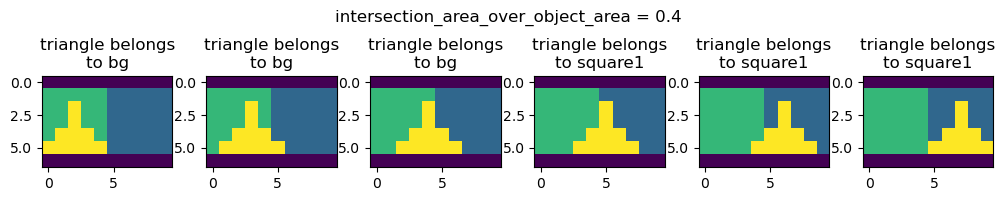

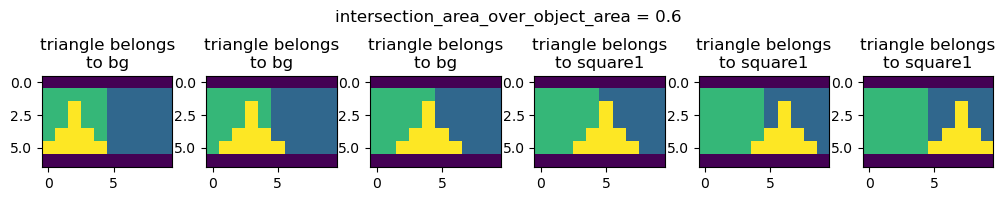

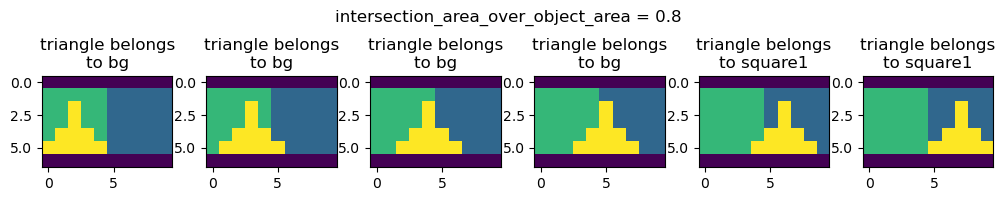

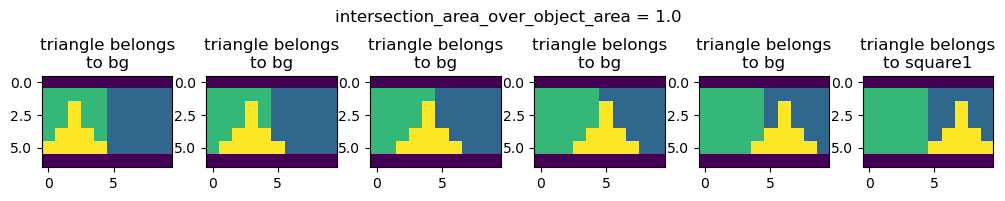

In [13]:
for i in range(6):
    intersection_area_over_object_area = i/5
    
    fig, ax = plt.subplots(1,6, figsize = [10,2])
    title = 'intersection_area_over_object_area = ' + str(intersection_area_over_object_area)
    plt.suptitle(title)
    for i, probe in enumerate(probe_list):
        ax[i].imshow(ref_labels2 + probe, vmax=3)
        value = highest_overlap(regionmask = probe, intensity_image = ref_labels,
                            overlap_threshold=intersection_area_over_object_area)
        ax[i].set_title('triangle belongs\nto ' + label_dict[value])
    plt.tight_layout()